# STAT 201 Group Project: Group 12

### Statistical Inference: Proportion Of Comparable Violent vs. Less Violent Crimes in the Day and Night
**Group Members:** Rashi Selarka, Alice Zhang, Medha Singh

In [1]:
library(tidyverse)
library(repr)
library(datateachr)
library(digest)
library(infer)
library(gridExtra)
library(cowplot)
library(caret)
library(modeldata)
library(tidymodels)
library(broom)
install.packages('BSDA')
library("BSDA")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘infer’ was built under R version 4.0.2”

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

 

## Introduction

Large-scale studies of crime data from the FBI<sup>1</sup> demonstrates that violent crimes often happen at night (Bannister, 2019). Articles from sources like _Security Magazine_<sup>2</sup> and the _Sleep Judge_<sup>3</sup> also demonstrate that violent crimes are likely to take place at night time. This statement seems reasonable since the victims are easier targets and witnesses become unlikely. We wanted to test this statement, and take it a step further by examining how different types of crimes may correlate with the time they take place at. We proposed doing this by looking at (seemingly) similar crimes and testing if they occur the same amount at similar times of the day. So, instead of comparing mean times, we are comparing the proportion of different crimes taking place in the day and in the night (since it is difficult to linearize a 24-hour cycle). The question we'll aim to answer is:

_**Is the proportion of violent / more serious crimes different from the proportion of less violent / less serious crimes in the day as well as in the night?**_

We'll be focusing our report on a two-tailed hypothesis test to answer this question - comparing the proportion of the violent crime of vehicle collision with _fatality_ vs. the proportion of the relatively less violent crime of vehicle collision with _injury_, and we'll do this in the day and in the night.

We have used the Vancouver crime data found on the Vancouver Police Department's website for our analysis, which consists of crime data on a year-by-year basis beginning in 2003, designed in a way to provide individuals with a general overview of criminal activity falling into several categories. Through this investigation, we hope to gain not just a better understanding of hypothesis testing, but also of the time of day we are more vulnerable to certain crimes (Brands, 2013).

## Methods: Preliminary Analysis

Note: The data has to be locally stored and loaded into the notebook since the website doesn't have an option to scrape it. It must be downloaded from https://geodash.vpd.ca/opendata/ onto the server home to be accessed.

Here, we load the data onto the notebook.

In [2]:
crime_data <- read_csv("/home/jupyter/crimedata_csv_all_years.csv")

Parsed with column specification:
cols(
  TYPE = col_character(),
  YEAR = col_double(),
  MONTH = col_double(),
  DAY = col_double(),
  HOUR = col_double(),
  MINUTE = col_double(),
  HUNDRED_BLOCK = col_character(),
  NEIGHBOURHOOD = col_character(),
  X = col_double(),
  Y = col_double()
)



In [3]:
head(crime_data)
print('Table 1')

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


[1] "Table 1"


Since our analysis is focused on different crimes occurring at different times, we'll be focusing on the TYPE of Crime and the HOUR at which it occurs. TYPE describes the nature of the crime committed, and the HOUR tells us what time exactly it took place as a two-digit field that indicates the hour time (in 24 hours format).

Of the various types of crime listed in the dataset, we have picked these 2 to analyse:
* **Vehicle Collision or Pedestrian Struck (with Fatality)**: Includes primarily pedestrian or cyclist struck and killed by a vehicle. It also includes vehicle to vehicle fatal accidents, however these incidents are fewer in number when compared to the overall data set.
* **Vehicle Collision or Pedestrian Struck (with Injury)**: Includes all categories of vehicle involved accidents with injuries. This includes pedestrian and cyclist involved incidents with injuries.

For simplicity, we selected only the columns of TYPE and HOUR. We go on to filter out the 2 specific crimes that we have chosen for our inference.

In [4]:
crime_data_grouped <- crime_data %>%
            group_by(TYPE) %>%
            select(TYPE, HOUR) %>%
            data.frame()


data_fatality_injury <- crime_data_grouped[ order( crime_data_grouped$HOUR), ] %>%
                select(TYPE, HOUR)%>%
                as.tibble()%>%
                filter(TYPE == "Vehicle Collision or Pedestrian Struck (with Injury)" | 
                       TYPE == "Vehicle Collision or Pedestrian Struck (with Fatality)")
head(data_fatality_injury)
print('Table 2')
tail(data_fatality_injury)
print('Table 3')

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


TYPE,HOUR
<chr>,<dbl>
Vehicle Collision or Pedestrian Struck (with Fatality),0
Vehicle Collision or Pedestrian Struck (with Fatality),0
Vehicle Collision or Pedestrian Struck (with Fatality),0
Vehicle Collision or Pedestrian Struck (with Fatality),0
Vehicle Collision or Pedestrian Struck (with Fatality),0
Vehicle Collision or Pedestrian Struck (with Fatality),0


[1] "Table 2"


TYPE,HOUR
<chr>,<dbl>
Vehicle Collision or Pedestrian Struck (with Injury),23
Vehicle Collision or Pedestrian Struck (with Injury),23
Vehicle Collision or Pedestrian Struck (with Injury),23
Vehicle Collision or Pedestrian Struck (with Injury),23
Vehicle Collision or Pedestrian Struck (with Injury),23
Vehicle Collision or Pedestrian Struck (with Injury),23


[1] "Table 3"


Here, we plot a boxplot of the data to better visualise and compare the distributions of the occurrence times of the crimes.

[1] "Fig. 1"


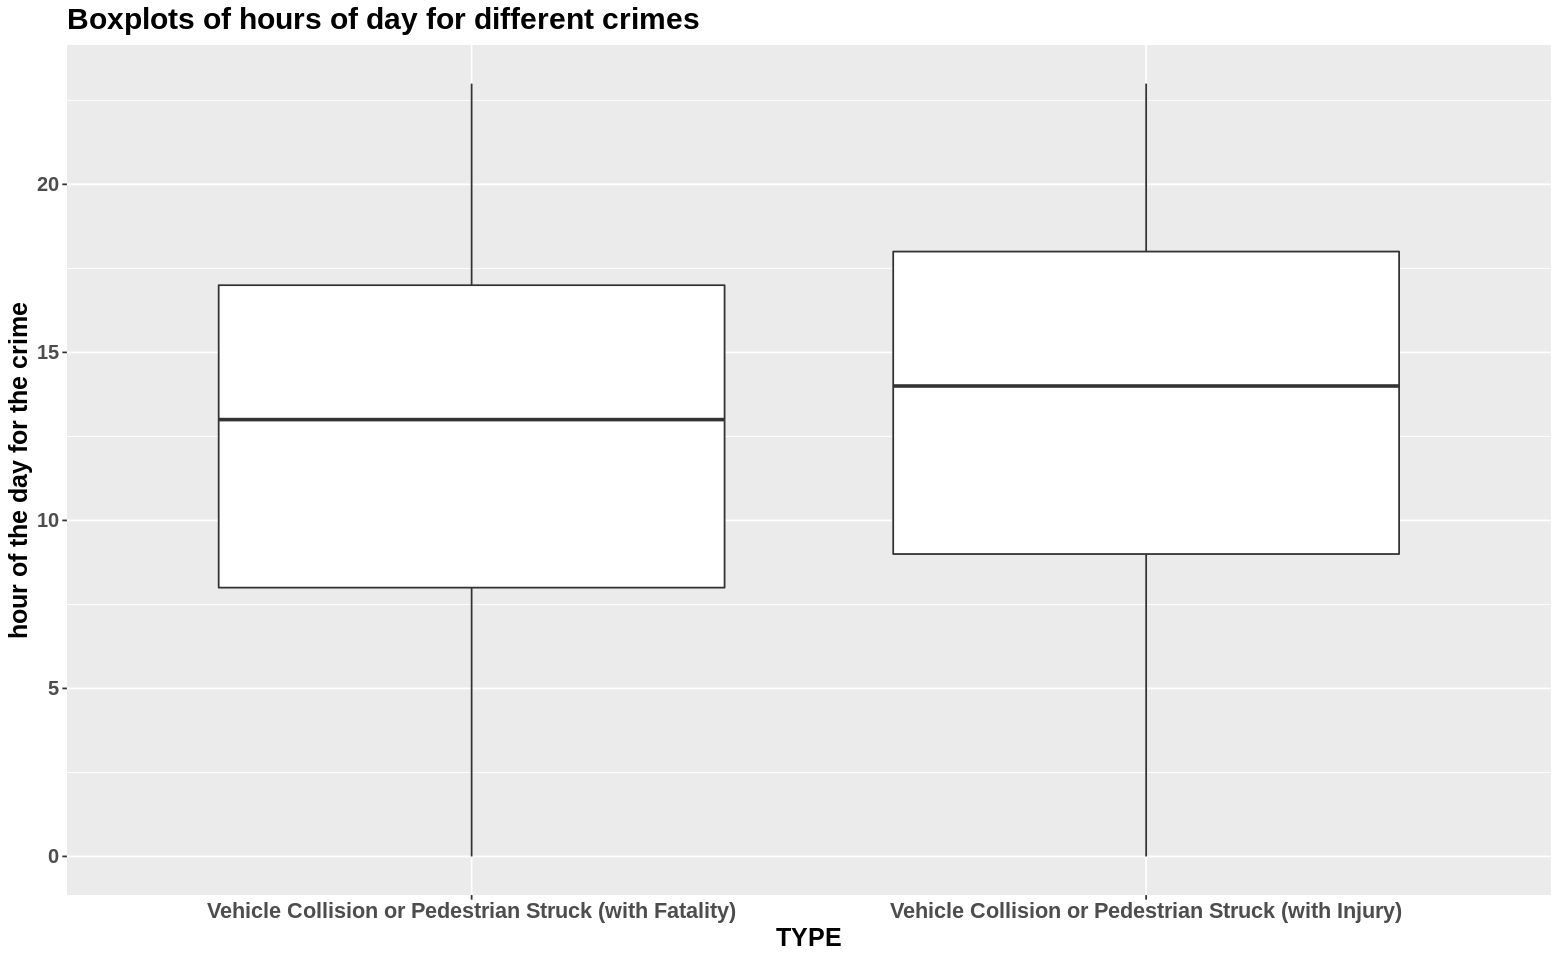

In [5]:
options(repr.plot.width = 13, repr.plot.height = 8)
cd_plot <- data_fatality_injury %>%  
    ggplot(aes(x = TYPE, y = HOUR)) + 
    geom_boxplot() + 
    ylab("hour of the day for the crime") +
    ggtitle("Boxplots of hours of day for different crimes") +
    theme(axis.text.x = element_text(size=13), 
          axis.text.y = element_text(size = 12), 
          text = element_text(face = "bold", size = 15)) 
cd_plot
print('Fig. 1')

This was an interesting revelation - we would have expected that , on average, more accidents with fatality would appear in the night than those with injury, but it appears from the boxplot that they might just be comparable in this sample. The raw data isn't very telling of the amount of each crime, so we wish to conduct a couple of two-sample z-tests to confirm whether the proportions of accidents with Fatality vs. with Injury are the same in the day and night.

Here, we are splitting the hours of the crime into "day" and "night", where **"day" is 0600 (6 AM) to 1800 (6 PM) (1800 not included), and "night" is 1800 (6 PM) to 0600 (6 AM) (0600 not included).**

<br>

<div>
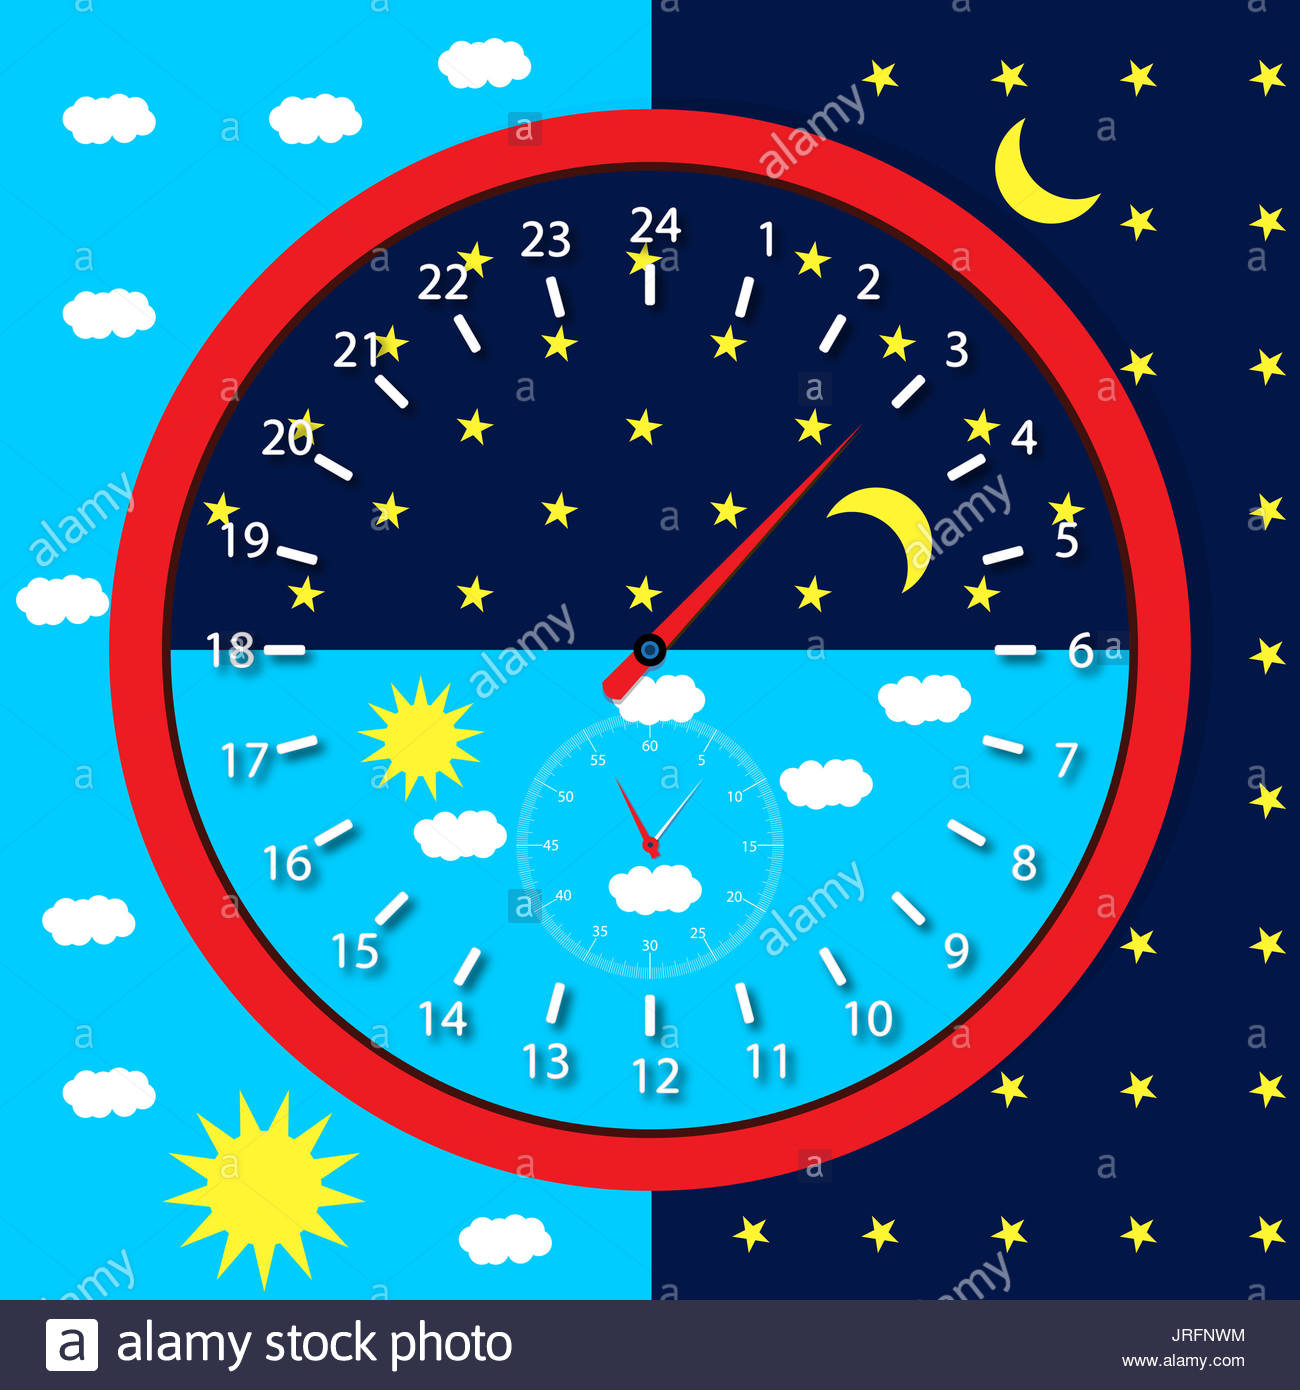
</div>
<div style="text-align: center"><i>Image from <a href="https://www.alamy.com/clock-face-day-and-night-sun-and-moon-24-hours-vector-illustration-image152166496.html">alamy.com</i></a></div>
<br>

In [6]:
re_type <- function(a) {
    if (a == "Vehicle Collision or Pedestrian Struck (with Fatality)"){
         a <- "Fatality"
    }else{
          a <- "Injury"
    } 
}
re_night <- function(a) {
    if (a){
         a <- "night"
    }else{
          a <- "day"
    } 
}

data_fatality_injury <- data_fatality_injury %>%
                        mutate(time = (0 <= HOUR & HOUR < 6|18 <= HOUR & HOUR < 0))
data_fatality_injury$TYPE <- lapply(data_fatality_injury$TYPE, re_type)
data_fatality_injury$time <- lapply(data_fatality_injury$time, re_night)
head(data_fatality_injury)
print('Table 4')
tail(data_fatality_injury)
print('Table 5')
head(data_fatality_injury %>% filter(time=="day"))
print('Table 6')
tail(data_fatality_injury %>% filter(time=="day"))
print('Table 7')

TYPE,HOUR,time
<list>,<dbl>,<list>
Fatality,0,night
Fatality,0,night
Fatality,0,night
Fatality,0,night
Fatality,0,night
Fatality,0,night


[1] "Table 4"


TYPE,HOUR,time
<list>,<dbl>,<list>
Injury,23,day
Injury,23,day
Injury,23,day
Injury,23,day
Injury,23,day
Injury,23,day


[1] "Table 5"


TYPE,HOUR,time
<list>,<dbl>,<list>
Fatality,6,day
Fatality,6,day
Fatality,6,day
Injury,6,day
Injury,6,day
Injury,6,day


[1] "Table 6"


TYPE,HOUR,time
<list>,<dbl>,<list>
Injury,23,day
Injury,23,day
Injury,23,day
Injury,23,day
Injury,23,day
Injury,23,day


[1] "Table 7"


In [7]:
# Split of Data:
data_fatality_injury %>%
    group_by(TYPE, time) %>%
    tally() %>%
    spread(TYPE, n)
print('Table 8')

time,Fatality,Injury
<list>,<int>,<int>
night,65,2489
day,236,23968


[1] "Table 8"


The population here is obviously unknown and our data is only a sample from it. However, it is a very large sample, and so we can use the Central Limit Theorem here to approximate standard Gaussian behaviour for the null model since the test statistic follows an approximately normal distribution. The Central Limit Theorem (CLT) roughly states that if a sample is large enough, the distribution of the sample is approximately Normal, regardless of the population's distribution.

With that, we can now use the `prop.test` function to conduct a two-sample z-test to see the difference in proportions.

Let $p_1$ be the proportion of Vehicle Collision or Pedestrian Struck (with Fatality) that happen in the day, and let $p_2$ be the proportion of Vehicle Collision or Pedestrian Struck (with Injury) that happen in the day.

**Our Hypotheses in both cases are:**

$H_0: p_1 - p_2 = 0$

$H_1: p_1 - p_2 \neq 0$

**Since the boxplot previously suggested a difference in proportions, we feel confident in our alternate hypothesis and will be testing at the 1% significance level.**

**To test $H_0$, our test statistic is:**

$Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}$

**and $\hat{p}$, the pooled proportion, is:**

$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$

## Methods: Hypothesis Test I: Vehicle Collision with Fatality vs. with Injury during the Day

Firstly, we will compare the proportions of the 2 crimes during the day.

Here, we get the data summary for our test - the sample sizes, sample proportions, and the difference between them.

In [8]:
day_summary <-
    data_fatality_injury %>% 
    group_by(TYPE) %>% 
    summarise(n = n(),
              p_hat = mean(time=="day"),
              `.groups` = "drop") %>% 
    pivot_wider(names_from = TYPE,
                values_from = c(n, p_hat)) %>% 
    mutate(prop_diff = p_hat_Fatality - p_hat_Injury)
day_summary
print('Table 9')

n_Fatality,n_Injury,p_hat_Fatality,p_hat_Injury,prop_diff
<int>,<int>,<dbl>,<dbl>,<dbl>
301,26457,0.7840532,0.9059228,-0.1218697


[1] "Table 9"


We then add the null standard error (denominator of test statistic) and the pooled proportion values.

In [9]:
day_summary <-
    day_summary %>% 
    mutate(p = (p_hat_Fatality * n_Fatality + p_hat_Injury * n_Injury)/(n_Injury+n_Fatality),
           null_std_error = sqrt(p*(1-p)*(1/n_Fatality+1/n_Injury))) %>% 
    mutate(z = (prop_diff / null_std_error),
           p_value = pnorm(z, lower.tail=FALSE)*2)%>%
    select(-p, -z)
day_summary
print('Table 10')

n_Fatality,n_Injury,p_hat_Fatality,p_hat_Injury,prop_diff,null_std_error,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
301,26457,0.7840532,0.9059228,-0.1218697,0.01703231,2


[1] "Table 10"


Now, we use the `broom::(tidy)` function `prop.test` to carry out the calculations for us.

In [10]:
day_prop_test <- tidy(
        prop.test(x = c(day_summary$n_Fatality * day_summary$p_hat_Fatality, day_summary$n_Injury * day_summary$p_hat_Injury),
                  n = c(day_summary$n_Fatality, day_summary$n_Injury),
                  correct = FALSE))

day_prop_test
print('Table 11')

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.7840532,0.9059228,51.19693,8.354919e-13,1,-0.1684874,-0.07525194,2-sample test for equality of proportions without continuity correction,two.sided


[1] "Table 11"


### Results I

#### Conclusion

The p-value we obtained is 0.0002, which is < 0.01. Therefore, at the 1% significance level we have sufficient evidence to reject the null hypothesis, i.e. there is a significant difference between the proportions of accidents with fatality and accidents with injury during the day.

## Methods: Hypothesis Test II: Vehicle Collision with Fatality vs. with Injury in the Night

Next, similar to what we did above, we will compare the proportions of the 2 crimes in the night.

Here, we get the data summary for our test - the sample sizes, sample proportions, and the difference between them.

In [11]:
night_summary <-
    data_fatality_injury %>% 
    group_by(TYPE) %>% 
    summarise(n = n(),
              p_hat = mean(time == "night"),
              `.groups` = "drop") %>% 
    pivot_wider(names_from = TYPE,
                values_from = c(n, p_hat)) %>% 
    mutate(prop_diff = p_hat_Fatality - p_hat_Injury)
night_summary
print('Table 12')

n_Fatality,n_Injury,p_hat_Fatality,p_hat_Injury,prop_diff
<int>,<int>,<dbl>,<dbl>,<dbl>
301,26457,0.2159468,0.09407718,0.1218697


[1] "Table 12"


We then add the null standard error (denominator of test statistic) and the pooled proportion values.

In [12]:
night_summary <-
    night_summary %>% 
    mutate(p = (p_hat_Fatality * n_Fatality + p_hat_Injury * n_Injury)/(n_Injury+n_Fatality),
           null_std_error = sqrt(p*(1-p)*(1/n_Fatality+1/n_Injury))) %>% 
    mutate(z = (prop_diff / null_std_error),
           p_value = pnorm(z, lower.tail=FALSE)*2)%>%
    select(-p, -z)
night_summary
print('Table 13')

n_Fatality,n_Injury,p_hat_Fatality,p_hat_Injury,prop_diff,null_std_error,p_value
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
301,26457,0.2159468,0.09407718,0.1218697,0.01703231,8.354919e-13


[1] "Table 13"


Now, we use the `broom::(tidy)` function `prop.test` to carry out the calculations for us.

In [13]:
night_prop_test <- tidy(
        prop.test(x = c(night_summary$n_Fatality * night_summary$p_hat_Fatality, night_summary$n_Injury * night_summary$p_hat_Injury),
                  n = c(night_summary$n_Fatality, night_summary$n_Injury),
                  correct = FALSE))

night_prop_test
print('Table 14')

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.2159468,0.09407718,51.19693,8.354919e-13,1,0.07525194,0.1684874,2-sample test for equality of proportions without continuity correction,two.sided


[1] "Table 14"


### Results II

#### Conclusion

The p-value we obtained is 0.0002, which is < 0.01. Therefore, at the 1% significance level we have sufficient evidence to reject the null hypothesis, i.e. there is a significant difference between the proportions of accidents with fatality and accidents with injury at night.

## Discussion

We started off expecting our results to corroborate the alternative hypotheses in the night but not in the day. During the day, we expected the amount of accidents with fatality to be significantly lower (i.e. different) than those with injury as drivers travel at lower speeds and tend to be more cautious; During the night more car accidents involving death are expected to happen later (i.e. a different amount) than ones with just injury, owing to drivers going at higher speeds at night, there being lower visibility, and more drunk and reckless drivers on the road.

Our results, indeed, matched up with our expectations. During the day, the estimate for fatality (0.535) was lower than that of injury (0.637), while during the night, the estimate for fatality (0.465) was higher than that of injury (0.363), and both of these differences were statistically significant (p-value < 0.01). We concluded, both during the day and night, that there was a significant difference in the proportion of collision with fatality and collision with injury in Vacouver. We can then generalise this to conclude that most likely, the proportion of violent crimes and the proportion of comparable relatively less violent crimes will be different during both the day and night, but perhaps in different ways in the day vs. in the night.

We didn't bootstrap here, since (a) eventhough the population is unknown to us, our data was an extremely large sample and CLT could be used here. (b) we were comparing proportions and using a 2-sample z-test, wherein bootstrapping wouldn't be necessary. We believe bootstrapping, depending on the number of reps, would probably give us slightly different results, but not too far off from what we currently have, and in no way better or worse.

Our inference most crucially provides a starting point for law enforcement to go about predicting the time during which certain types of crimes are likely to occur. It is also useful for the general adult population to know about, so one would know what time of day they are more vulnerable and should be taking more precautions.

The questions that arise for the future are many - other than time of day, what are other predictors we could look at: perhaps certain months when crime spikes? Also, if perhaps the month and time of day are related? Maybe crime could occur at earlier hours in the winter months because it gets dark sooner, so then the definition of "day" and "night" we have taken would vary in different regions. It's worth looking into a more diverse dataset that could provide information about what the crime was vs. what the criminal was actually convicted of or what punishment they served - potential miscarriage of justice is an extremely relevant issue in the world currently, and statistical insights into it would largely help build a case when necessary.

## References

Bannister J, O’Sullivan A, Bates E. Place and time in the Criminology of Place. Theoretical Criminology. 2019;23(3):315-332. doi:10.1177/1362480617733726

Brands, J., Schwanen, T., & Aalst, I. V. (2013). Fear of crime and affective ambiguities in the night-time economy. Urban Studies, 52(3), 439-455. doi:10.1177/0042098013505652

Vancouver Police Department: Crime Data. Retrieved from https://geodash.vpd.ca/opendata/

<sup>1</sup>Violent Crime. (2018, September 10). Retrieved from https://ucr.fbi.gov/crime-in-the-u.s/2017/crime-in-the-u.s.-2017/topic-pages/violent-crime

<sup>2</sup>Violent Crimes Most Likely to Occur At Night. (2019, June 14). Retrieved from https://www.securitymagazine.com/articles/90384-murder-robbery-and-driving-while-impaired-happen-at-night

<sup>3</sup>Crimes that Happen While You Sleep. (2020, November 04). Retrieved from https://www.thesleepjudge.com/crimes-that-happen-while-you-sleep/